make Robinson Projection  
using map_templateb_table.html   
use the world map file prepare with: split_for_robinson.ipynb

In [16]:
from collections import defaultdict
import vmapper
import os
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.ops import transform, split
import shapely
from pyproj import Transformer, CRS, Proj

import matplotlib.pyplot as plt
import seaborn as sns

from catppuccin_palette import catppuccin as cpc
import mplcatppuccin
from mplcatppuccin.palette import load_color
from mplcatppuccin.colormaps import get_colormap_from_list
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
#from jinja2 import Environment, PackageLoader, select_autoescape
import jinja2
from tqdm.notebook import tqdm

[ 9999 -9999    60   120    90    30     0   180  -150  -120   -90   -60
   -30   150]


<Axes: >

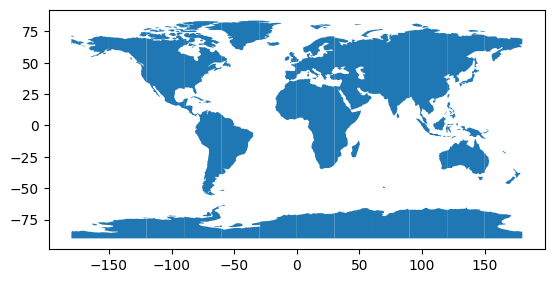

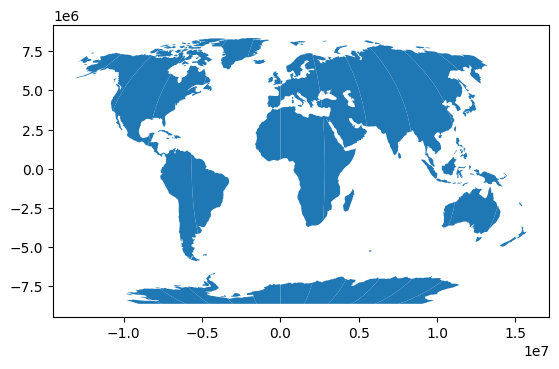

In [27]:
#fp = '../data/natural_earth/ne_110m_admin_0_countries2.shp'
fp = '../data/natural_earth/ne_110m_admin_0_countries2_robin.shp'
#fp = 'data/natural_earth/ne_110m_land.shp'
gdf = gpd.read_file(fp)
#gdf2 = gdf.dissolve().explode(index_parts=True)
gdf4 = gdf.copy()
#gdf4['cat'] = [int(float(lon0)) if lon0.isnumeric() else lon0 for lon0 in gdf4['cat']]
print(gdf4['cat'].unique())
#gdf3['area'] = gdf3.area
#gdf4 = gdf3[gdf3['area']>1]
#gdf4 = gdf4.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
gdf4.plot()
#gdf.plot()
this_crs = '+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' # robinson
gdf4.to_crs(this_crs).plot()

<Axes: >

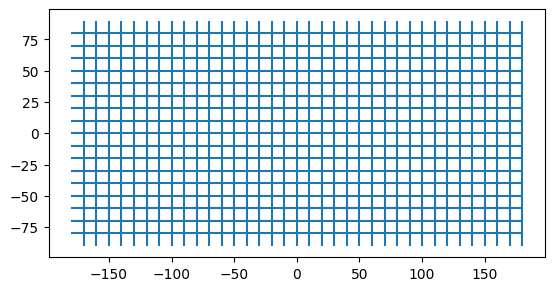

In [4]:
fp = '../data/natural_earth/ne_110m_graticules_10.shp'
grid = gpd.read_file(fp)
grid['display0'] = [d.replace(' ', '') for d in grid['display']]

grid.plot()

In [5]:
grid.head()

,degrees,direction,display,scalerank,dd,geometry,display0
0,80,N,80 N,4,80,"LINESTRING (180.00000 79.99848, 179.99664 79.9...",80N
1,70,N,70 N,4,70,"LINESTRING (180.00000 69.99847, 179.99664 69.9...",70N
2,60,N,60 N,4,60,"LINESTRING (180.00000 59.99866, 179.99664 59.9...",60N
3,50,N,50 N,4,50,"LINESTRING (179.99990 49.99876, 179.99664 49.9...",50N
4,40,N,40 N,4,40,"LINESTRING (179.99990 39.99875, 179.99664 39.9...",40N


In [6]:
gdf4.head()

,id,cat,alt_x,alt_y,geometry
0,0,ori,NaN,NaN,"POLYGON ((-163.71290 -78.59567, -163.71290 -78..."
1,1,cut,NaN,NaN,"POLYGON ((-122.40624 -73.32462, -121.21151 -73..."
2,2,60,-120.01,-74.028602,"POLYGON ((-120.01000 -73.64667, -119.99000 -73..."
3,3,cut,NaN,NaN,"POLYGON ((-119.99000 -73.64910, -119.91885 -73..."
4,4,ori,NaN,NaN,"POLYGON ((-100.78346 -72.50162, -101.80187 -72..."


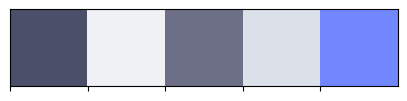

In [10]:
DARK = load_color('latte', 'text')
WHITE = load_color('latte', 'base')
LIGHTGRAY = load_color('latte', 'crust')
GRAY = load_color('latte', 'subtext0')
LINE = load_color('latte', 'lavender')
sns.palplot([DARK, WHITE, GRAY, LIGHTGRAY, LINE])

In [11]:
def generate_svg2(m, the_gdf, the_grid, title, vis):
    #m = vmapper.Map(interactive=False, params={'bgcolor': WHITE})
    m.add_geodataframe(the_grid, layername='{}-grid'.format(title.replace(' ', '_')), 
        draw_setting=dict(labelby='display0', idby='display2'),
        strokecolor=LINE, opacity=0.7,
        strokewidth=30000, showlabel=False, visibility=vis)
    m.add_geodataframe(the_gdf, layername='{}-land'.format(title.replace(' ', '_')), 
        draw_setting=dict(labelby='id', idby='id2'), 
        color=DARK, opacity=0.6, strokecolor=DARK, strokewidth=0, showlabel=False, 
        visibility=vis)
    #m.add_title(title+' Projection')

In [12]:

for x in [x*30 for x in range(12)]:
    if x>180:
        x-=180
        x = -180+x
    print(x)

0
30
60
90
120
150
180
-150
-120
-90
-60
-30


In [13]:
projections = {}

for x in [x*30 for x in range(12)]:
    if x>180:
        x-=180
        x = -180+x
    x2 = 'E{}'.format(x) if x>0 else 'W{}'.format(abs(x)) if x<0 else 'EW{}'.format(x)
    n = x2
    #print(n)
    this_crs = '+proj=robin +lon_0={} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' .format(x)
    projections[n] = (this_crs, x)
    #print(this_crs)
    #gdf4.to_crs(this_crs).plot(fc='none', ec='k')
    #grid.to_crs(this_crs).plot(fc='none', ec='k')
len(projections)


12

In [14]:
projections

{'EW0': ('+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  0),
 'E30': ('+proj=robin +lon_0=30 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  30),
 'E60': ('+proj=robin +lon_0=60 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  60),
 'E90': ('+proj=robin +lon_0=90 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  90),
 'E120': ('+proj=robin +lon_0=120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  120),
 'E150': ('+proj=robin +lon_0=150 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  150),
 'E180': ('+proj=robin +lon_0=180 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  180),
 'W150': ('+proj=robin +lon_0=-150 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  -150),
 'W120': ('+proj=robin +lon_0=-120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  -120),
 'W90': ('+proj=robin +lon_0=-90 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  -90),
 'W60': ('+proj=robin

In [48]:
alt_gdf

,id,cat,alt_x,alt_y,geometry
20,20,30,-150.01,59.597515,"POLYGON ((-150.00999 59.59751, -150.00999 59.5..."
136,136,30,-150.01,-90.000000,"POLYGON ((-150.00999 -90.00000, -150.00999 -90..."
138,138,30,-150.01,-84.299837,"POLYGON ((-150.00999 -84.29984, -150.00999 -84..."
140,140,30,-150.01,-79.344533,"POLYGON ((-150.00999 -79.34453, -150.00999 -79..."


In [29]:
gdf4['cat']

0      9999
1     -9999
2        60
3     -9999
4      9999
       ... 
208    9999
209   -9999
210     -30
211   -9999
212    9999
Name: cat, Length: 213, dtype: int64

In [51]:
m = vmapper.Map(interactive=False, params={'bgcolor': WHITE})


check = 0
proj_list = []
projections2 = {}
for k in projections:
    crs, lon0 = projections[k]
    projections2[k] = crs
    vis = 'hidden' if check>0 else 'visible'
    the_grid = grid.to_crs(crs).copy()
    #the_gdf = gdf4
    #the_gdf = split_globe(lon0, the_gdf).to_crs(crs)
    the_gdf = gdf4[gdf4['cat']!=lon0].copy()
    alt_gdf = gdf4[gdf4['cat']==lon0].copy()
    #print(alt_gdf)
    tmp_geom = [Point(altx, 0).buffer(0.00001) 
                for altx, alty in zip(alt_gdf['alt_x'], alt_gdf['alt_y'])]
    alt_gdf['geometry'] = tmp_geom
    the_gdf = pd.concat([the_gdf, alt_gdf])
    the_gdf = the_gdf.to_crs(crs)
    #the_gdf.plot()
    k2 = k.replace(' ', '_')
    the_gdf['id2'] = ['{}-{}'.format(k2, i) for i in the_gdf['id']]
    the_grid['display2'] = ['{}-{}'.format(k2, i) for i in the_grid['display0']]
    #print(the_gdf)
    generate_svg2(m, the_gdf, the_grid, k, vis)
    proj_list.append(k)
    print(k)
    check+=1
    #if check==2:
    #    break
    #break

EW0
E30
E60
E90
E120
E150
E180
W150
W120
W90
W60
W30


In [52]:
svgText = m.make_scene()
#print(outputText)


In [53]:
temp_vars = {'first_title': proj_list[0], 
             'first_proj4': projections2[proj_list[0]],
             'content': svgText,
             'projections_collection': proj_list[1:],
             'projs': projections2,
}
temp_vars['first_title']

'EW0'

In [54]:
templateLoader = jinja2.FileSystemLoader( searchpath="." )
templateEnv = jinja2.Environment( loader=templateLoader )
TEMPLATE_FILE = "map_templateb_robin.html"

template = templateEnv.get_template( TEMPLATE_FILE )
outputText = template.render( temp_vars )

outputfn = 'test5b.html'

with open(outputfn, 'wb') as f:
    f.write(outputText.encode("utf-8"))